# Lazyfit Feature Overview

Lazyfit provides a convienent wrapper for the scipy.curve_fit() fitting tool.
It includes a number of built-in fit models for which initial fits parameters are automatically generated. 

This notebook demonstrates all the functionality of the Lazyfit library.
See LINK for a list of fit models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import lazyfit

# Generate some test data

As an example, consider a dataset resembling a Lorentzian plus a linear background.
Fitting a Lorentzian and extracting its position and width is a common problem in spectroscopy.

In [2]:
# test data parameters
A = 500 # amplitude
x0 = 100 # peak position
bg = 50 # constant background
FWHM = 2 # lorentzian full width half maximum

# generate test data
x = np.linspace(x0-10, x0+10, 50)
y = A/(1+(x-x0)**2/(FWHM/2)**2) + bg
y = np.random.poisson(lam=y) # add poissonian noise to data
dy = np.sqrt(y) # retroactively estimate errors

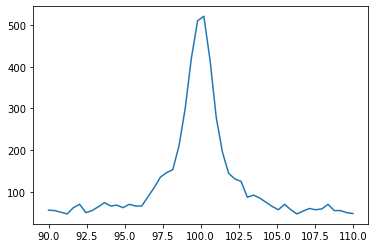

In [3]:
plt.plot(x, y)

# Fully automatic fitting and plotting

As a bare minimum, envoke the lazyfit.fit() method with the fit model name as a string and the x and y data

In [4]:
fit = lazyfit.fit('lorentz', x, y)

This will return a lazyfit. You can immediately plot the fit by running fit.plot(). 

This displays the fit parameters in addition to N DOF, the number of degress of freedom (number of datapoints minus number of fit parameters)

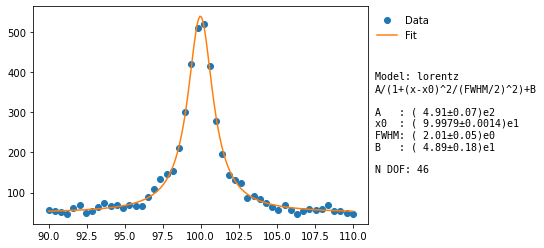

In [5]:
fig = fit.plot() # plots the data and fit and returns a figure handle

## Fitting with errors

lazyfit also takes y-data errors as an optional argument

In [6]:
fit = lazyfit.fit('lorentz', x, y, dy=dy)

Plotting will then represent data as errorbars and add additional statistics:

chi2 = Chi squared sum

chi2red = Chi squared normalised to number of degrees of freedom

p = Probability of null hypothesis given chisquared sum, and degrees of freedom.

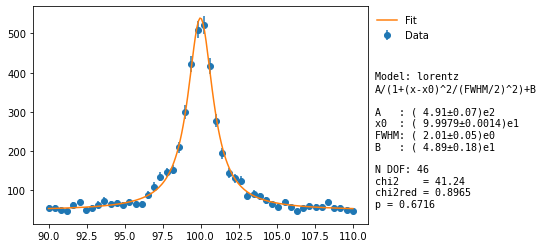

In [7]:
fig = fit.plot() # plots the data and fit and returns a figure handle

## Retrieving fit parameters 

In [8]:
fit.params # get fit parameters in the order they are specified in the fit model

array([490.70768231,  99.97871458,   2.0140335 ,  48.85450846])

In [9]:
fit.errors # get errors on the fit parameters (this is the square root of the covariance matrix diagonal)

array([6.73729269, 0.0137847 , 0.04617315, 1.83212491])

In [10]:
fit.params_dict # get fit paramters as a dictionary

{'A': 490.70768231317373,
 'x0': 99.97871458078865,
 'FWHM': 2.01403349688953,
 'B': 48.85450845755117}

In [11]:
fit.errors_dict # fit errors as a dictionary

{'A': 6.737292686863256,
 'x0': 0.013784695502299778,
 'FWHM': 0.04617314571657592,
 'B': 1.8321249078728687}

In [12]:
fit.COVB # covarience matrix

array([[ 4.53911127e+01,  1.34514758e-05, -1.74934527e-01,
        -8.13428397e-01],
       [ 1.34514758e-05,  1.90017830e-04, -1.29858979e-07,
         2.00047173e-06],
       [-1.74934527e-01, -1.29858979e-07,  2.13195939e-03,
        -4.50514664e-02],
       [-8.13428397e-01,  2.00047173e-06, -4.50514664e-02,
         3.35668168e+00]])

## Making predictions

In [13]:
fit.f # fit function

<function lazyfit.models._func_lorentz(x, A, x0, FWHM, B)>

In [14]:
fit.predict(100) # evalue the fit function at a given x-value given the fit paramters

539.343051659417

In [15]:
# access the data passed to the fitting routine:
fit.x;
fit.y;
fit.dy;

# More plotting functionality

### Logarithmic y axis

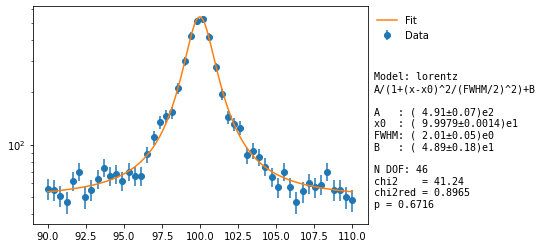

In [16]:
fig = fit.plot(logy=True)

### Show guess

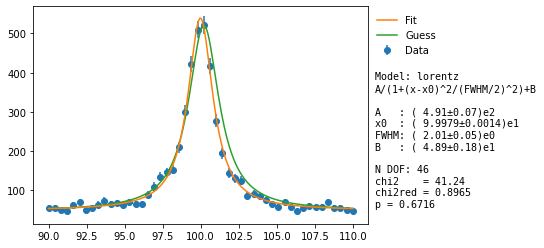

In [17]:
fit.plot(plot_guess = True);

You can also plot the guess alone in case the fit has failed

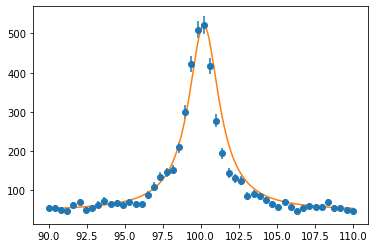

In [18]:
fig = fit.plot_guess();

### Plot residuals

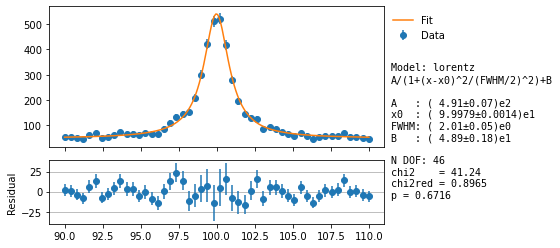

In [19]:
fit.plot(plot_residuals=True);

### Add axes labels

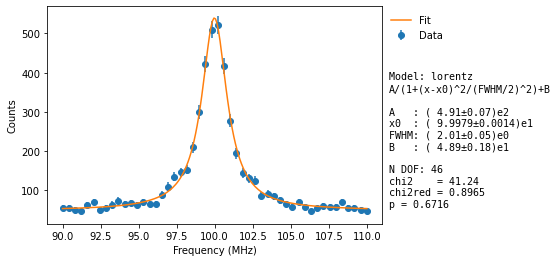

In [20]:
fit.plot(xlabel='Frequency (MHz)', ylabel='Counts');

### Additional keyword arguments

'N' : Number of points in the fit and guess curves. Increase to make fit curve look smoother. Default is 200.

'figsize' : Tupple used to set figure size

'fmt' : Marker format used for data plotting. Default is 'o'

'print params' : Toggles text output on the right of the figure. Default is True.    

# More fitting functionality

### Fixing parameters

You may wish to fix one or more parameters to a known value. To do this you can pass dictionary with the name of the fit parameters and their value. For example, lets fix the backgroud of the example lorentzian to 0.

In [21]:
fit = lazyfit.fit('lorentz', x, y, dy, fix={'B':0})

You will see that the fit has changed as that the list of fit parameters indicates that B is fixed to 0.

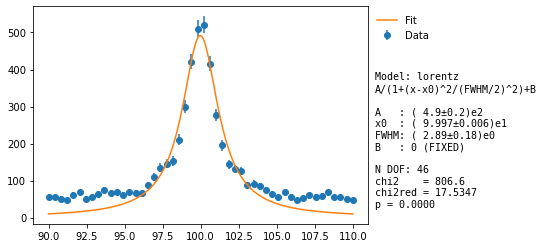

In [22]:
fit.plot();

### Custum limits or guesses

By default, lazyfit generates its own guess and limits for the fit parameters to facilitate a successful fit. These can be overwridden at any time with keyword arguments

Manual guess requires providing a list:

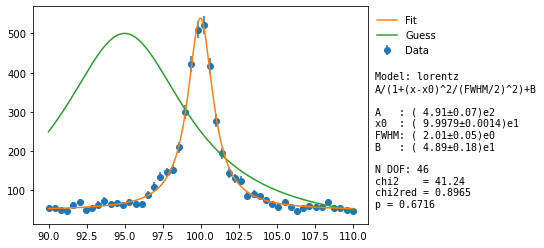

In [23]:
fit = lazyfit.fit('lorentz', x, y, dy, guess = [500, 95, 10,0]) # provide manual guess
fit.plot(plot_guess=True);

Manual bounds requires a tupple of lower bound and upper bound lists.
Beware, the scipy fitting may produce errors if bounds are too restrictive

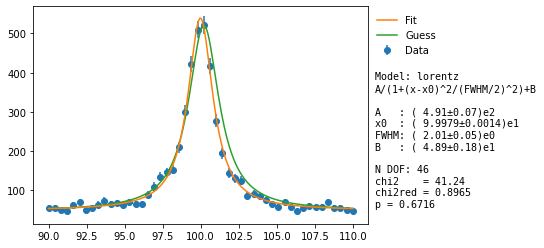

In [24]:
fit = lazyfit.fit('lorentz', x, y, dy, bounds = ([0,0,0,0], [600, 200, 10,200])) # provide manual guess
fit.plot(plot_guess=True);

### Passing on scipy fit options

You can pass a dictionary of keyword arguments to the scipy.curve_fit() routine using the 'options' keyword of lazyfit.fit(). This is helpfull eg. if you need to increase the max number of itterations

In [25]:
fit = lazyfit.fit('lorentz', x, y, dy, options={'maxfev':10000})

# Debugging tips

By calling lazyfit.fit() the fitting routine is automatically called. If you wish to inspect the data and parameter guess before fitting you can create the Wrapper object without lazyfit.Wrapper() using the same keyword arguments as lazyfit.fit()

In [26]:
wrapper = lazyfit.Wrapper('lorentz', x, y, dy) # same arguments and keywords a

In [27]:
wrapper.guess # inspect the fit parameter guess

[474, 100.20408163265306, 2.448979591836732, 47]

In [28]:
wrapper.fit() # invoke the fitting

# Adding custom fit models

Fitmodels are defined as objects of the Lazyfit.Models.LazyFitModel class. Here is an example on how to define a new model from scratch for fitting the function f(x) = A*sqrt(x)+B:

In [29]:
def func_sqrt(x, A, B): 
    '''the fit model which is evaluated. x is always first argument followed by bit parameters'''
    return A * np.sqrt(x) + B

def guess_sqrt(x, y):
    '''function for getting a guess on fit parameters'''
    B = np.min(y)
    A = (np.max(y)-B)/np.sqrt(np.max(x))
    return [A,B]

def bounds_sqrt(x, y):
    '''function for setting parameter bounds'''
    lb = [-np.inf, -np.inf]
    ub = [np.inf, np.inf]
    return lb, ub

# pass a name (as string), model function, guess, and bounds, and math expression to the function.
model_sqrt = lazyfit.models.LazyFitModel('My sqrt', func_sqrt, guess_sqrt, bounds_sqrt, 'A*sqrt(x)+B') 

Note that guess, bounds, and the math expression are optional!

In [30]:
# generate test data
x2 = np.linspace(0,10,50)
y2 = 2*np.sqrt(x2) + 1 + np.random.normal(scale=0.2, size=x2.size)

In [31]:
fit = lazyfit.fit(model_sqrt, x2, y2, dy=0.2)

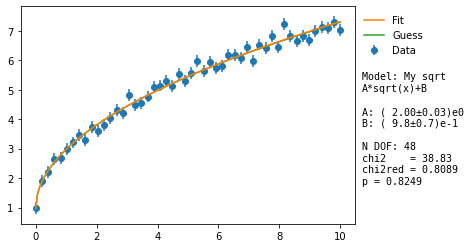

In [32]:
fit.plot(plot_guess=True);

Also note that printing the fitmodel displays the model name and fit parameters

In [33]:
model_sqrt

<LazyFitModel. Model name: My sqrt. Fit parameters: ['A', 'B'].